## Filtering the Dataframe properly
1. order msut sum to 45
2. MatchID must be a valid number
3. Lane must be between 1 = 3
4. Hero ID must be between 1 - 138
5. MatchID must be unique and sum to exactly 10

In [1]:
import pandas as pd
df = pd.read_csv('large_amounts_of_data.csv')

# Keep only the first 10 consecutive rows of each match ID to prevent duplicated data
df_cleaned = df.groupby('MatchID').head(10)

# put the cleaned up data into a new file
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned.to_csv('cleaned_data.csv', index=False)

df = pd.read_csv("cleaned_data.csv")
# Added in the bracer key late so the early models dont have it but it just means they were 0 so we can just make those values go to zero
df["bracer"].fillna(int(0), inplace=True)

#1. the ordrr must sum to 45
grouped = df.groupby("MatchID")["Order"].sum()
filtered_match_ids = grouped[grouped == 45].index
# Create a new DataFrame with only the rows corresponding to the filtered "MatchID"
df = df[df["MatchID"].isin(filtered_match_ids)]

# 2 and 3 remove the values of the dataframe where the match id is invalid or the lane is biggerr than 3 as this is ambigous and bad data 
cleaned_df = df[(df['MatchID'] > 100000) & (df["Lane"] < 4) & (df["Lane"] > 0)]

#4. hero id's between
cleaned_df = cleaned_df[cleaned_df["Hero ID"].between(1, 138)]

# 5. A valid match id must have exactly 10 matches
matchID_counts = cleaned_df['MatchID'].value_counts()
valid_matchID = matchID_counts[matchID_counts == 10].index
final_df = cleaned_df[cleaned_df["MatchID"].isin(valid_matchID)]
df_cleaned.to_csv('cleaned_data.csv', index=False)

# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', None)
final_df


,Hero ID,Team,Order,MatchID,Lane,smoke_of_deceit,boots,flask,blood_grenade,clarity,...,ring_of_regen,sobi_mask,null_talisman,buckler,headdress,ring_of_basilius,wind_lace,boots_of_elves,dust,bracer
10,13,1,9,7425319964,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
11,46,1,6,7425319964,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
12,138,1,2,7425319964,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
13,83,1,5,7425319964,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
14,77,1,0,7425319964,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117741,136,0,4,6856407334,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
117742,52,0,9,6856407334,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
117743,85,0,1,6856407334,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
117744,92,0,7,6856407334,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [15]:
columns_sum_less_than_50 = final_df.columns[final_df.sum() < 50].tolist()
sum_of_columns = final_df[columns_sum_less_than_50].sum()
print(sum_of_columns)


chainmail            17
infused_raindrops     0
dust                 17
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X1 = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
X2 = final_df[["Hero ID", "Team", "Order",]]
y = final_df["Lane"]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the decision tree model using the training data
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = decision_tree_model.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(predictions, y_test)
print("Accuracy on the test set:", accuracy)

#https://huggingface.co/models?pipeline_tag=tabular-classification&sort=trending

## Standard Random Forrest Model 

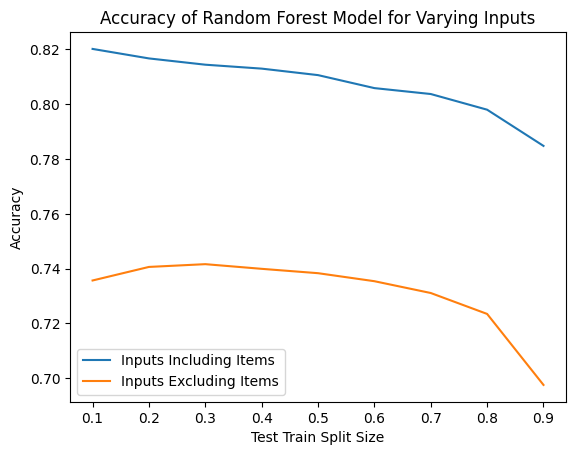

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X1 = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
X2 = final_df[["Hero ID", "Team", "Order"]]
y = final_df["Lane"]

# Vary the test train split size from 0.1 to 0.9
split_sizes = np.arange(0.1, 1.0, 0.1)

# Lists to store accuracy values for X1 and X2
accuracy_X1 = []
accuracy_X2 = []

# Iterate through different split sizes
for split_size in split_sizes:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=split_size, random_state=42)

    # Create and fit the random forest model using the training data
    random_forest_model = RandomForestClassifier()  # Use RandomForestClassifier
    random_forest_model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = random_forest_model.predict(X_test)

    # Calculate accuracy on the test set and store it
    accuracy_X1.append(accuracy_score(predictions, y_test))

    # Repeat the process for X2
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=split_size, random_state=42)
    random_forest_model.fit(X_train, y_train)
    predictions = random_forest_model.predict(X_test)
    accuracy_X2.append(accuracy_score(predictions, y_test))

# Plot the results
plt.plot(split_sizes, accuracy_X1, label='Inputs Including Items')
plt.plot(split_sizes, accuracy_X2, label='Inputs Excluding Items')
plt.xlabel('Test Train Split Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy of Random Forest Model for Varying Inputs")
plt.show()


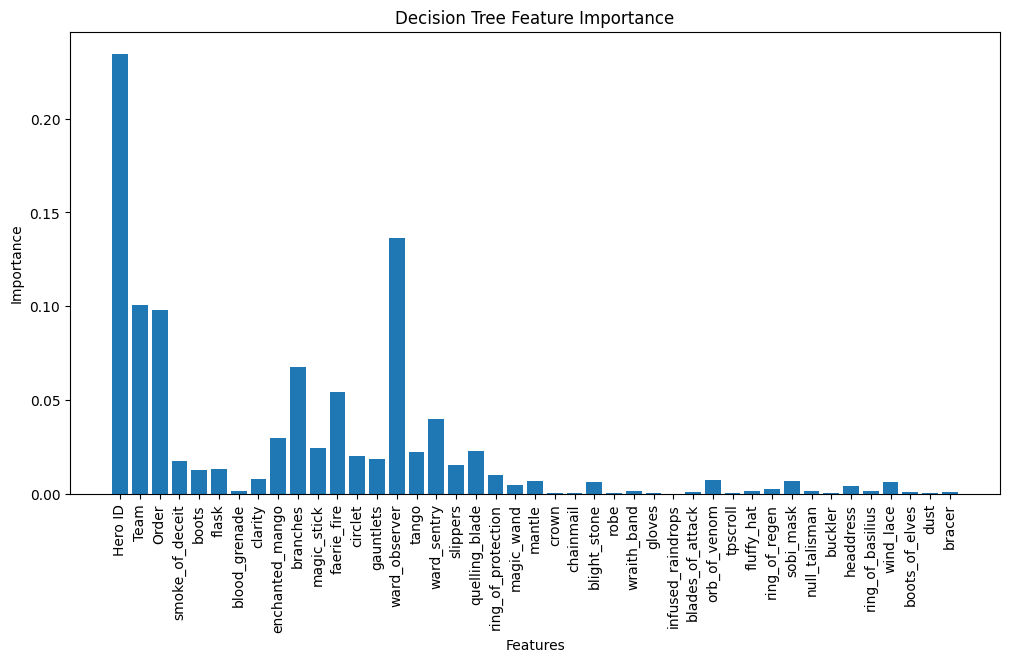

In [31]:
# Assuming final_df is your dataframe containing the data
# ...

# Create and fit the decision tree model using the entire dataset
decision_tree_model = RandomForestClassifier()
decision_tree_model.fit(X1, y)

# Get feature importances
feature_importances = decision_tree_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(X1.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision Tree Feature Importance')
plt.xticks(rotation=90)
plt.show()


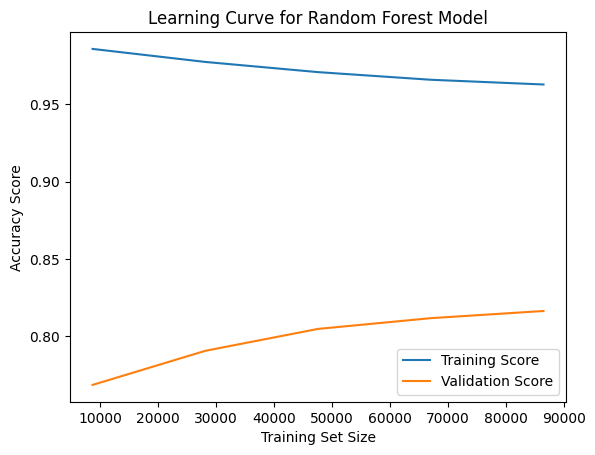

In [33]:
from sklearn.model_selection import learning_curve

# Assuming `random_forest_model` is your trained Random Forest model
train_sizes, train_scores, test_scores = learning_curve(random_forest_model, X1, y, cv=5)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve for Random Forest Model')
plt.legend()
plt.show()


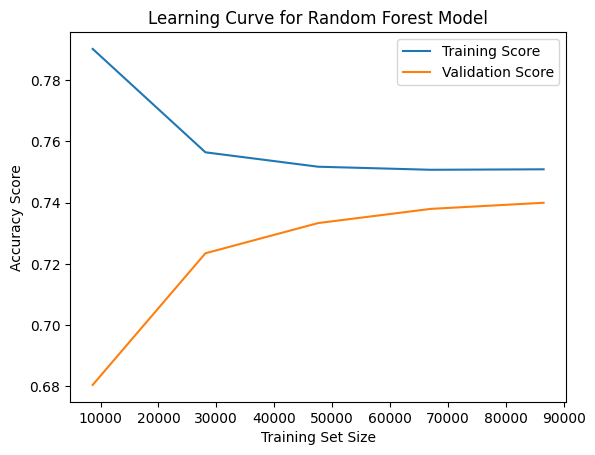

In [34]:
from sklearn.model_selection import learning_curve

# Assuming `random_forest_model` is your trained Random Forest model
train_sizes, train_scores, test_scores = learning_curve(random_forest_model, X2, y, cv=5)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve for Random Forest Model')
plt.legend()
plt.show()


## BEST Implementation Random Forrest made up of decsision trees of each unique Match ID

In [19]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

final_df = final_df.iloc[10000:20000]
# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
y = final_df["Lane"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Group data by MatchID
grouped_data = final_df.groupby("MatchID")

# Initialize an empty list to store individual decision trees
individual_trees = []

# Train a decision tree for each group (unique MatchID)
for name, group in grouped_data:
    # Extract features and target for the current group
    X_group = group[X.columns]
    y_group = group["Lane"]

    # Create a decision tree model and train it
    decision_tree_model = DecisionTreeClassifier()
    decision_tree_model.fit(X_group, y_group)

    # Append the trained decision tree to the list
    individual_trees.append(decision_tree_model)

# Now, you have a list of decision trees, and you can use them as needed.

# Assemble individual decision trees into a Random Forest
random_forest_model = RandomForestClassifier(n_estimators=len(individual_trees), random_state=42)

# Train the Random Forest using the entire dataset
random_forest_model.fit(X, y)

# Evaluate on the original features
y_pred_original = random_forest_model.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
print("Accuracy on original features:", accuracy_original)

Accuracy on original features: 0.983


## Confusion Matrix Analyzing the Results from the best model

In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
y = final_df["Lane"]

# Randomly shuffle the rows
# shuffled_df = final_df.sample(frac=1, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Group data by MatchID
grouped_data = final_df.groupby("MatchID")

# Initialize an empty list to store individual decision trees
individual_trees = []

# Train a decision tree for each group (unique MatchID)
for name, group in grouped_data:
    # Extract features and target for the current group
    X_group = group[X.columns]
    y_group = group["Lane"]

    # Create a decision tree model and train it
    decision_tree_model = DecisionTreeClassifier()
    decision_tree_model.fit(X_group, y_group)

    # Append the trained decision tree to the list
    individual_trees.append(decision_tree_model)

# Now, you have a list of decision trees, and you can use them as needed.

# Assemble individual decision trees into a Random Forest
random_forest_model = RandomForestClassifier(n_estimators=len(individual_trees), random_state=42)

# Train the Random Forest using the entire dataset
random_forest_model.fit(X, y)

# Evaluate on the original features
y_pred_original = random_forest_model.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
print("Accuracy on original features:", accuracy_original)


: 

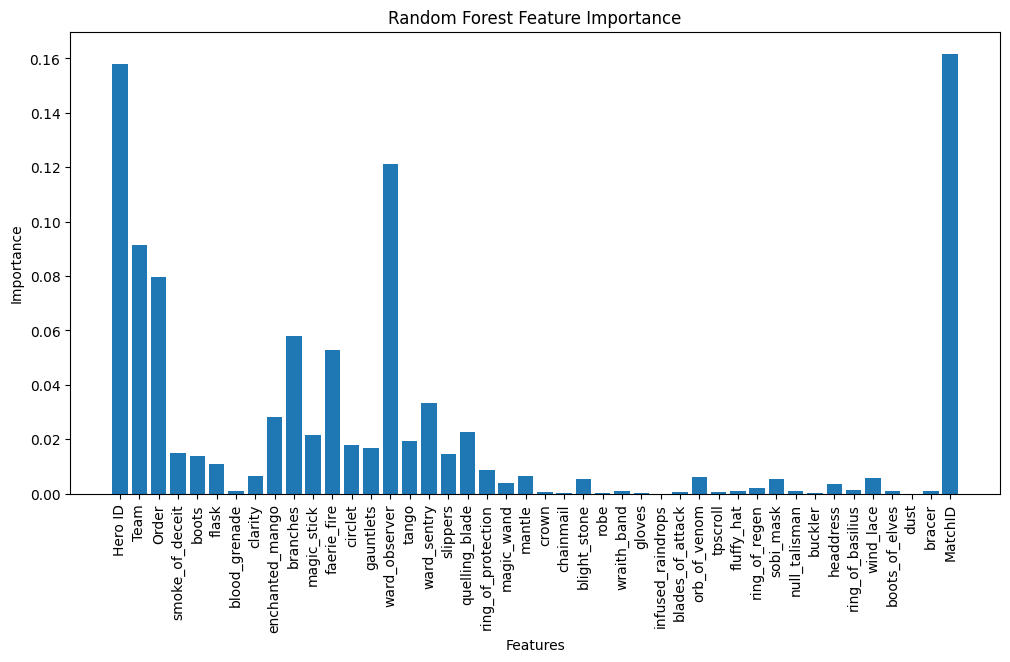

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]]
y = final_df["Lane"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(X.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.show()


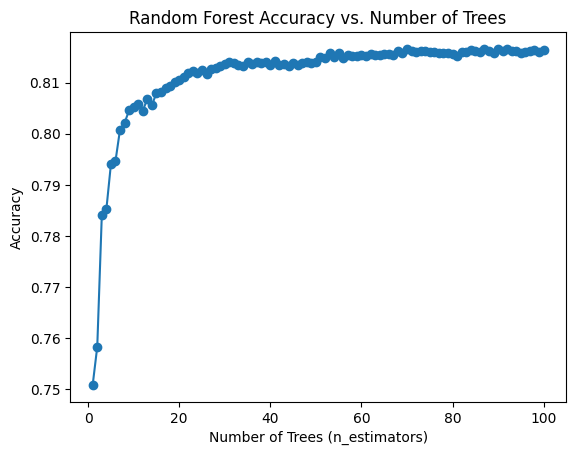

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
y = final_df["Lane"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vary the number of trees from 1 to 100 and record accuracy
n_estimators_range = range(1, 101)
accuracy_scores = []

for n_estimators in n_estimators_range:
    # Create a Random Forest model with the current number of trees
    random_forest_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Train the model
    random_forest_model.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = random_forest_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the results
plt.plot(n_estimators_range, accuracy_scores, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.show()


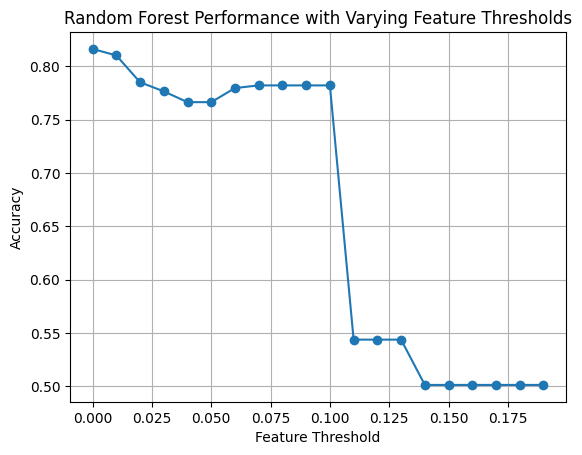

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Assuming final_df is your dataframe containing the data
# X contains the features, and y contains the target variable
X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
y = final_df["Lane"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Lists to store threshold values and corresponding accuracies
thresholds = np.arange(0, 0.2, 0.01)
accuracies = []

# Iterate through different thresholds
for threshold in thresholds:
    # Feature selection based on importance
    sfm = SelectFromModel(random_forest_model, threshold=threshold)
    sfm.fit(X_train, y_train)

    # Check if any feature is selected
    if np.sum(sfm.get_support()) > 0:
        # Transform the data to include only selected features
        X_train_selected = sfm.transform(X_train)
        X_test_selected = sfm.transform(X_test)

        # Create and train a new model using selected features
        random_forest_model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
        random_forest_model_selected.fit(X_train_selected, y_train)

        # Evaluate on the selected features
        y_pred_selected = random_forest_model_selected.predict(X_test_selected)
        accuracy_selected = accuracy_score(y_test, y_pred_selected)
        accuracies.append(accuracy_selected)
    else:
        print(f"No features selected for threshold {threshold}")

# Plot the results
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Feature Threshold')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance with Varying Feature Thresholds')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming X_selected is your feature matrix with selected features
# and y is your target variable

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_selected, y)

# Get feature importance
feature_importance = rf_model.feature_importances_

# Set your threshold
threshold = 0.075  # Adjust this value based on your preference

# Filter features based on the threshold
selected_features = X.columns[feature_importance >= threshold]

# Plot or display feature importance
plt.barh(range(len(selected_features)), feature_importance[feature_importance >= threshold], align='center')
plt.yticks(range(len(selected_features)), selected_features)
plt.xlabel('Feature Importance')
plt.title('Selected Features based on Importance')
plt.show()


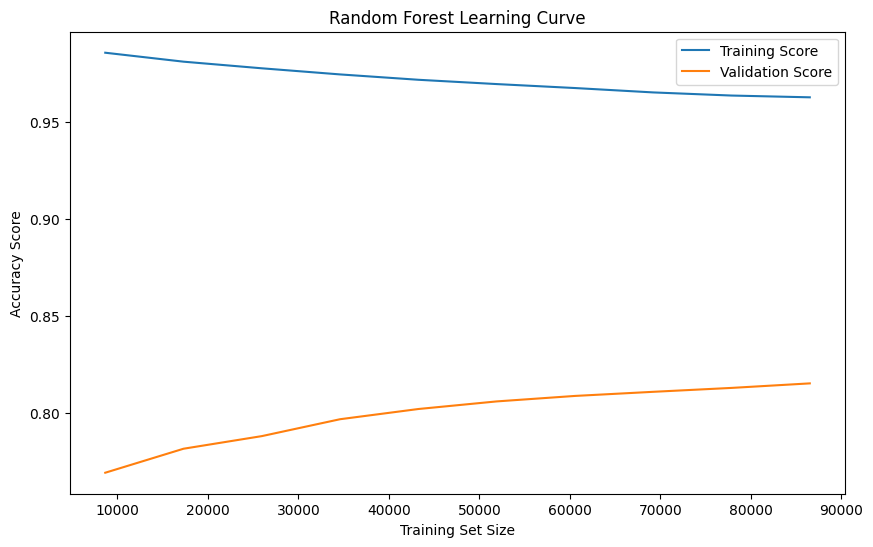

In [39]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    random_forest_model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Learning Curve')
plt.legend()
plt.show()


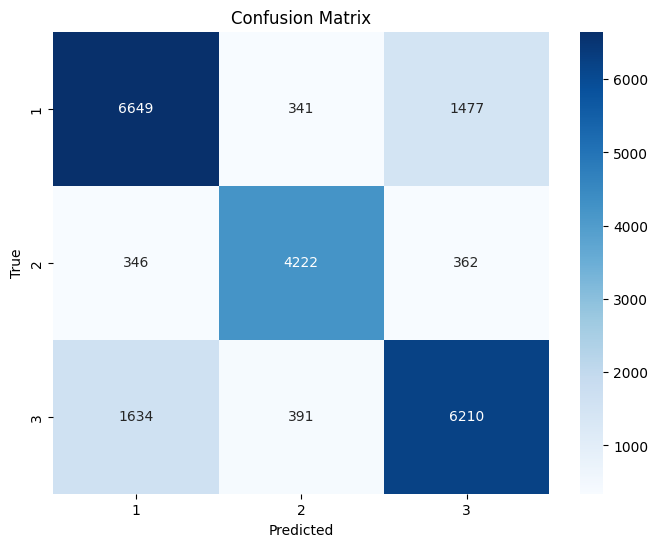

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming final_df is your dataframe containing the data
# ...

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Create and fit the decision tree model using the training data
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = decision_tree_model.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=decision_tree_model.classes_, yticklabels=decision_tree_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


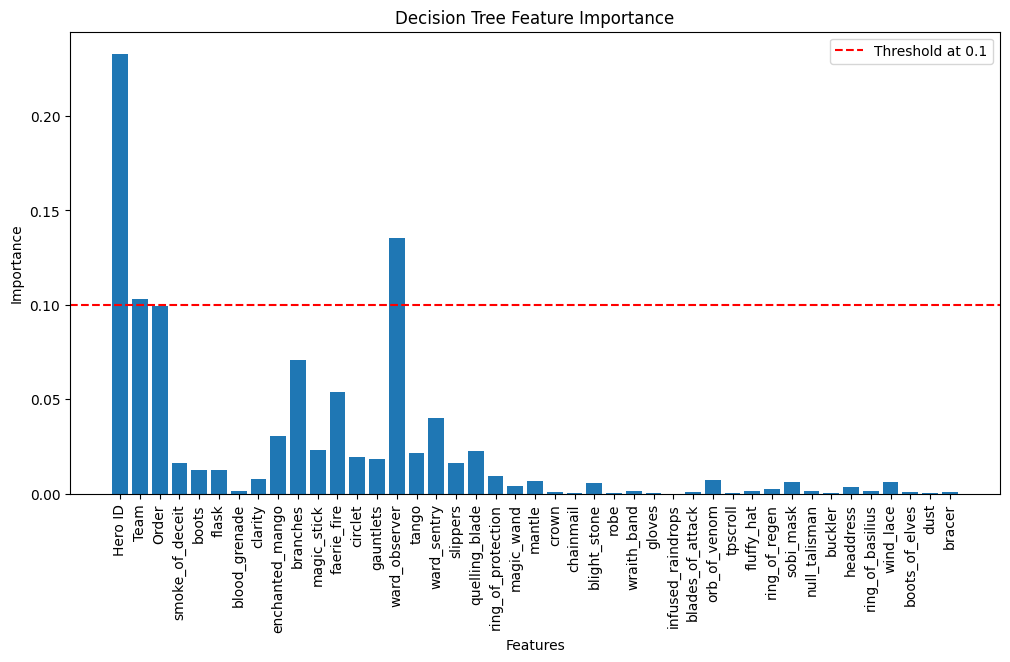

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Assuming final_df is your dataframe containing the data
# X1 contains the features, and y contains the target variable

# Create and fit the decision tree model using the entire dataset
decision_tree_model = RandomForestClassifier()
decision_tree_model.fit(X1, y)

# Get feature importances
feature_importances = decision_tree_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(X1.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision Tree Feature Importance')
plt.xticks(rotation=90)

# Add a horizontal line at y = 0.1
plt.axhline(y=0.1, color='red', linestyle='--', label='Threshold at 0.1')

plt.legend()
plt.show()


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load your dataset
# final_df = pd.read_csv('your_dataset.csv')

# Assuming `special_features` is a list of the four important features
# special_features = ["Order", "Team", "Hero ID", "ward_observer"]
special_features = ["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
              "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
              "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
              "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
              "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
              "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer", "MatchID"]

# Extract the subset of your dataset
X_special = final_df[special_features]
y = final_df["Lane"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_special, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN model
k = 3  # Choose the number of neighbors (k) based on your requirements
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7753790680473372
Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.77      0.75      8467
           2       0.92      0.85      0.88      4930
           3       0.74      0.73      0.74      8235

    accuracy                           0.78     21632
   macro avg       0.80      0.79      0.79     21632
weighted avg       0.78      0.78      0.78     21632

Confusion Matrix:
[[6545  158 1764]
 [ 384 4182  364]
 [2007  182 6046]]


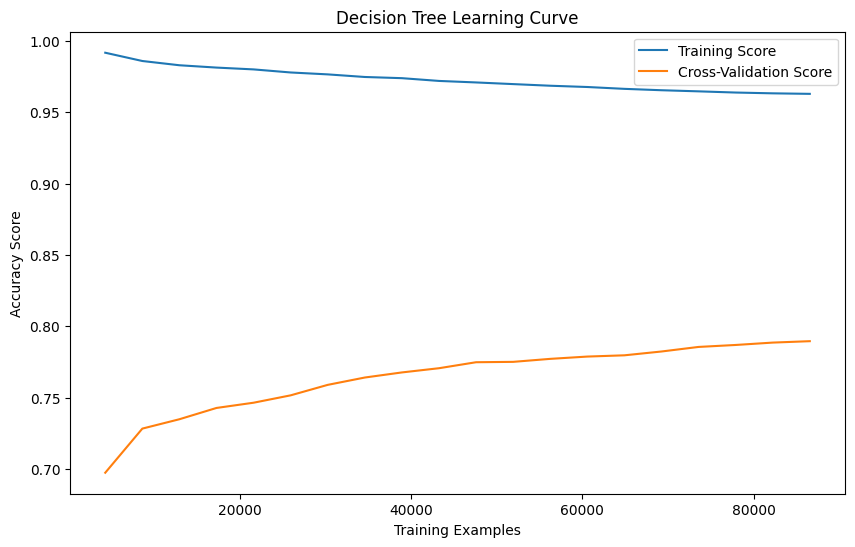

In [13]:
from sklearn.model_selection import learning_curve

# Assuming final_df is your dataframe containing the data
# ...

# Create and fit the decision tree model
decision_tree_model = DecisionTreeClassifier()

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(decision_tree_model, X1, y, cv=5, train_sizes=np.linspace(0.05, 1.0, 20))

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.title('Decision Tree Learning Curve')
plt.legend()
plt.show()


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load your data into a Pandas DataFrame
# Assuming your DataFrame is named df
# You might need to adjust the path or method based on your actual data loading process
# df = pd.read_csv('your_data.csv')

# Prepare your features (X) and target variable (y)
X = final_df[["Hero ID", "Team", "Order", "smoke_of_deceit", "boots", "flask", "blood_grenade", "clarity", "enchanted_mango",
        "branches", "magic_stick", "faerie_fire", "circlet", "gauntlets", "ward_observer", "tango", "ward_sentry",
        "slippers", "quelling_blade", "ring_of_protection", "magic_wand", "mantle", "crown", "chainmail",
        "blight_stone", "robe", "wraith_band", "gloves", "infused_raindrops", "blades_of_attack", "orb_of_venom",
        "tpscroll", "fluffy_hat", "ring_of_regen", "sobi_mask", "null_talisman", "buckler", "headdress",
        "ring_of_basilius", "wind_lace", "boots_of_elves", "dust", "bracer"]]
y = final_df["Lane"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel='linear')  # You can use other kernels like 'rbf' or 'poly'
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(predictions, y_test)
print("Accuracy on the test set:", accuracy)


Accuracy on the test set: 0.5844119822485208


In [ ]:
def getOrderOnTeam(row):
    match = final_df[final_df["MatchID" == row["MatchID"]] & final_df["Team"== row["Team"]]]
    # sort in descending order
    match = match.sort_values(by = "Order", ascending = False)
    # get the index
    return match["Hero ID" == row["Hero ID"]].index[0]

    
final_df["OrderOnTeam"] = final_df.apply(getOrderOnTeam, axis = 1)

final_df.head(10)
    

final_df

## Sanity checks on the Data 

In [ ]:
# #confirmation check that we cleaned properly
result = final_df.groupby("MatchID")["Order"].sum()
result = result.reset_index()
filter = result[result["Order"] != 45]
filter

# final_df["MatchID"].value_counts().sort_values(ascending=True)



If you want to use a neural network with a 10*44 matrix as input instead of a 1-D input vector, you can employ a specific type of neural network architecture known as a "2D Convolutional Neural Network" or "2D CNN." 2D CNNs are well-suited for processing grid-like data such as images or matrices. In your case, where you have a matrix of 10 rows and 44 columns as input for each match, a 2D CNN can be an appropriate choice. 
Please let me know if you have any questions.

## ConvolutionNeural Network for 2D matrix

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming df is your DataFrame

# Prepare your input data (features)
X = df.iloc[:, 5:].values  # Select columns from 6th to the end (excluding "Lane")
X = X.reshape(-1, 10, 44, 1)  # Reshape to (number_of_samples, 10, 44, 1)

# Prepare your target data (labels)
y = df["Lane"].values.reshape(-1, 1)  # Assuming "Lane" is the target variable

# Perform one-hot encoding on the labels
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and compile the 2D CNN model (as defined in the previous answer)


# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load your data into a Pandas DataFrame
# Assuming your DataFrame is named df
# You might need to adjust the path or method based on your actual data loading process
# df = pd.read_csv('your_data.csv')

# Extract features and labels
X = df.iloc[:, 5:].values  # Assuming columns from 6th to the end are features
num_heroes = 10
num_features = X.shape[1] // num_heroes
num_matches = len(df['MatchID'].unique())

# Extract features and labels
X = df.iloc[:, 5:].values  # Assuming columns from 6th to the end are features
num_heroes = 10
num_features = X.shape[1] // num_heroes

# Calculate the number of matches based on unique MatchID values
num_matches = len(df['MatchID'].unique())

# Reshape X
X = X.reshape(num_matches, num_heroes, num_features, 1)

# Prepare your target data (labels)
y = df["Lane"].values.reshape(-1, 1)  # Assuming "Lane" is the target variable

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_heroes, num_features, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
